# Домашка 5

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

__Выполнил все пункты задания.__ Хотя подбор параметров в конце никак не улучшил метрики одной из моделей с дефолтными гипер-параметрами.

In [1]:
#импортируем библиотеки

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score 
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
#загружаем данные

df = pd.read_csv("churn_data.csv")
print(df.shape)
df.head(3)

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

### Подготовим данные и фичи

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7500, 14), (7500,), (2500, 14), (2500,))

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


In [6]:
#определим категориальные и вещественные фичи
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
#ячейка для проверки / теста отдельных фичей
test = Pipeline([
                ('selector', FeatureSelector(column='IsActiveMember')),
                ('ohe', OHEEncoder(key='IsActiveMember'))
            ])
test.fit(X_train)
test.transform(X_test).head(3)

,IsActiveMember_0,IsActiveMember_1
9394,0,1
898,1,0
2398,0,1


In [8]:
#соберем все транформеры вместе
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

In [9]:
#проверим какие фичи у нас получаются
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit(X_train)
pd.DataFrame(feature_processing.transform(X_train.head(3)))

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,-0.735507,0.015266,0.673160,2.535034,-1.640810
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.024427,-0.652609,-1.207724,0.804242,-0.079272
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.808295,-0.461788,-0.356937,0.804242,-0.996840


### Обучим модели и оценим метрики

In [10]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels, title=''):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

  
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title(title + ' - Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   

    plt.show()

Logres - Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568, Roc_auc=0.772


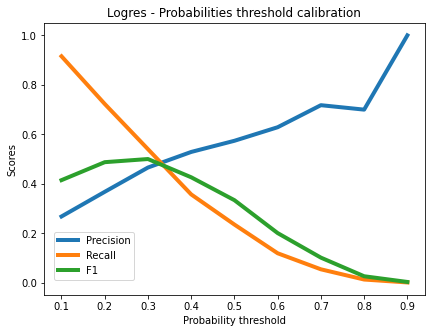

Forest - Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629, Roc_auc=0.864


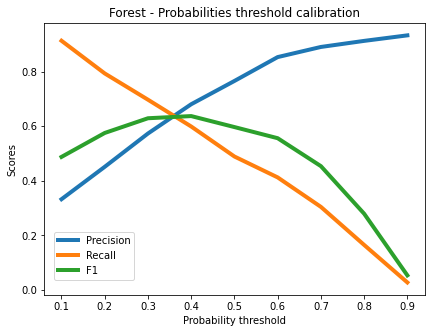

Skl gboost - Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, Roc_auc=0.876


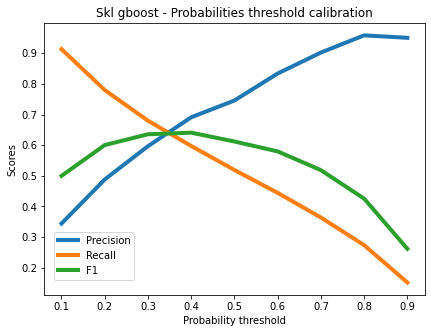

Catboost - Best Threshold=0.386362, F-Score=0.647, Precision=0.661, Recall=0.633, Roc_auc=0.877


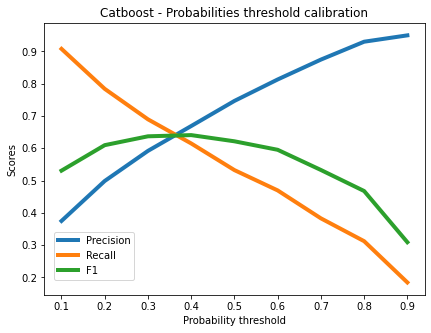

In [13]:
classifiers_names = ['Logres', 'Forest', 'Skl gboost', 'Catboost']

classifiers = [LogisticRegression(random_state=42), 
               RandomForestClassifier(random_state=42), 
               GradientBoostingClassifier(random_state=42),
               CatBoostClassifier(random_state=42, verbose=False)
              ]

TN = []
TP = []
FP = []
FN = []
total = []
profit_base = []
profit_05 = []
profit_06 = []
profit_07 = []

for i in range(len(classifiers_names)):
    
    cls_name = classifiers_names[i] 
    cls = classifiers[i]
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', cls),
    ])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    
    roc = roc_auc_score(y_test, preds)
    
    print('%s - Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (cls_name,
                                                                        thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc))
    #можно плюсом график f1, precision, recall нарисовать
    show_proba_calibration_plots(preds, y_test, cls_name)
    
    #порог когда f1 максимальная
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    TN.append(cnf_matrix[0,0])
    TP.append(cnf_matrix[1,1])
    FP.append(cnf_matrix[0,1])
    FN.append(cnf_matrix[1,0])
    total.append(TP[-1] + TN[-1] + FP[-1] + FN[-1])
    profit_base.append(TP[-1] * 2 - (TP[-1] + FP[-1]) * 1)
    
    # порог 0.5
    cnf_matrix = confusion_matrix(y_test, preds>0.5)
    profit_05.append(cnf_matrix[1,1] * 2 - (cnf_matrix[1,1] + cnf_matrix[0,1]) * 1)
    
    # порог 0.6
    cnf_matrix = confusion_matrix(y_test, preds>0.6)
    profit_06.append(cnf_matrix[1,1] * 2 - (cnf_matrix[1,1] + cnf_matrix[0,1]) * 1)
    
    # порог 0.7
    cnf_matrix = confusion_matrix(y_test, preds>0.7)
    profit_07.append(cnf_matrix[1,1] * 2 - (cnf_matrix[1,1] + cnf_matrix[0,1]) * 1)
    


In [14]:
n = np.array([classifiers_names, TN, TP, FP, FN, total, profit_base, profit_05, profit_06, profit_07]).T
scores = pd.DataFrame(n, columns=['models', 'TN', 'TP', 'FP', 'FN', 'total', 'profit (trh=optimum)', 
                                  'profit (trh=0.5)', 'profit (trh=0.6)', 'profit (trh=0.7)'])
scores

,models,TN,TP,FP,FN,total,profit (trh=optimum),profit (trh=0.5),profit (trh=0.6),profit (trh=0.7)
0,Logres,1655,288,336,221,2500,-48,31,25,17
1,Forest,1833,314,158,195,2500,156,173,174,136
2,Skl gboost,1863,303,128,206,2500,175,174,181,165
3,Catboost,1826,321,165,188,2500,156,179,184,167


#### Какая DS метрика более подходящая ?
Так как нам необходимо, скорее всего потребуется подобрать порог, то метрики f1, precision, recall будут более удобными.
Порог потребуется подобрать, чтобы получить наиболее высокую экономическую эффективность, которая не обязательно будет, там, где F1-максимальная. 

#### Сделать оценку экономической эффективности
Посчитали грубо, код очень не оптимальный, но зато результаты получились интересными.

Оказалось, что для максимизации экономической эффективности, порог лучше подкрутить вручную, причем в большую сторону

Как видим максимальный профит для логистической регрессии получается при пороге 0.5, для остальных моделей при пороге 0.6

### Подбор параметров и оценка эффективности лучшей модели

Лучший результат показал catboost. Попробуем подобрать параметры для него и еще раз оценить DS-метрики и экономическую эффективность

In [15]:
%%time

params={'classifier__n_estimators': [10, 20, 50, 100],
        'classifier__max_depth':[5, 10, None],
        }

pipeline = Pipeline([
        ('features',feats),
        ('classifier', CatBoostClassifier(random_state=42, verbose=False)),
    ])

grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 47.9 s


{'classifier__max_depth': 5, 'classifier__n_estimators': 20}

Теперь обучимся на лучших параметрах

In [16]:
pipeline = Pipeline([
        ('features',feats),
        ('classifier', CatBoostClassifier(random_state=42, verbose=False, max_depth=5, n_estimators=20)),
    ])

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

Catboost - Best Threshold=0.361550, F-Score=0.646, Precision=0.643, Recall=0.650, Roc_auc=0.877


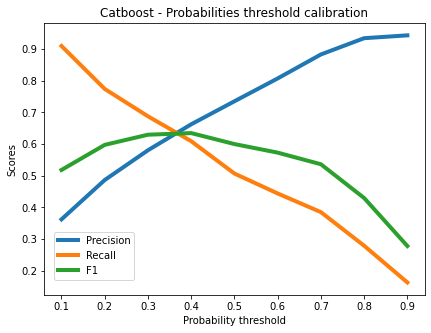

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

print('%s - Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (cls_name,
                                                                    thresholds[ix], 
                                                                    fscore[ix],
                                                                    precision[ix],
                                                                    recall[ix],
                                                                    roc))

show_proba_calibration_plots(preds, y_test, cls_name)

TN = []
TP = []
FP = []
FN = []
total = []
profit_base = []
profit_05 = []
profit_06 = []
profit_07 = []

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
TN.append(cnf_matrix[0,0])
TP.append(cnf_matrix[1,1])
FP.append(cnf_matrix[0,1])
FN.append(cnf_matrix[1,0])
total.append(TP[-1] + TN[-1] + FP[-1] + FN[-1])
profit_base.append(TP[-1] * 2 - (TP[-1] + FP[-1]) * 1)

# порог 0.5
cnf_matrix = confusion_matrix(y_test, preds>0.5)
profit_05.append(cnf_matrix[1,1] * 2 - (cnf_matrix[1,1] + cnf_matrix[0,1]) * 1)

# порог 0.6
cnf_matrix = confusion_matrix(y_test, preds>0.6)
profit_06.append(cnf_matrix[1,1] * 2 - (cnf_matrix[1,1] + cnf_matrix[0,1]) * 1)

# порог 0.7
cnf_matrix = confusion_matrix(y_test, preds>0.7)
profit_07.append(cnf_matrix[1,1] * 2 - (cnf_matrix[1,1] + cnf_matrix[0,1]) * 1)

In [18]:
n = np.array([['catboost'], TN, TP, FP, FN, total, profit_base, profit_05, profit_06, profit_07]).T
scores = pd.DataFrame(n, columns=['models', 'TN', 'TP', 'FP', 'FN', 'total', 'profit (trh=optimum)', 
                                  'profit (trh=0.5)', 'profit (trh=0.6)', 'profit (trh=0.7)'])
scores

,models,TN,TP,FP,FN,total,profit (trh=optimum),profit (trh=0.5),profit (trh=0.6),profit (trh=0.7)
0,catboost,1807,330,184,179,2500,146,165,172,170


#### Результат
Более удачные параметры подобрать не удалось. С дефолтными параметрами catboost показал более хороший результат. Возможно надо было перебирать намного больше параметров, но это займет очень много времени. И самое главное, по опыту прошлых курсовых catboost с параметрами "из коробки" всегда показывал такой результат, что и при попытках оптимизации. Возможно, я еще не умею достаточно хорошо "его готовить"